In [1]:
import numpy as np
import essentia
import essentia.standard as es
from scipy.signal import hilbert
import utils as u
import matplotlib.pyplot as plt

SSL_DSET_PATH = '/Volumes/Production Tools/coding_projs/THESIS/data_preprocesses/data/Diff-SSL-G-Comp'
DRY_PATH = '/processed_normalized'
WET_PATH = '/processed_ground_truth'

SR = 44100

# Hilbert Envelope vs RMS

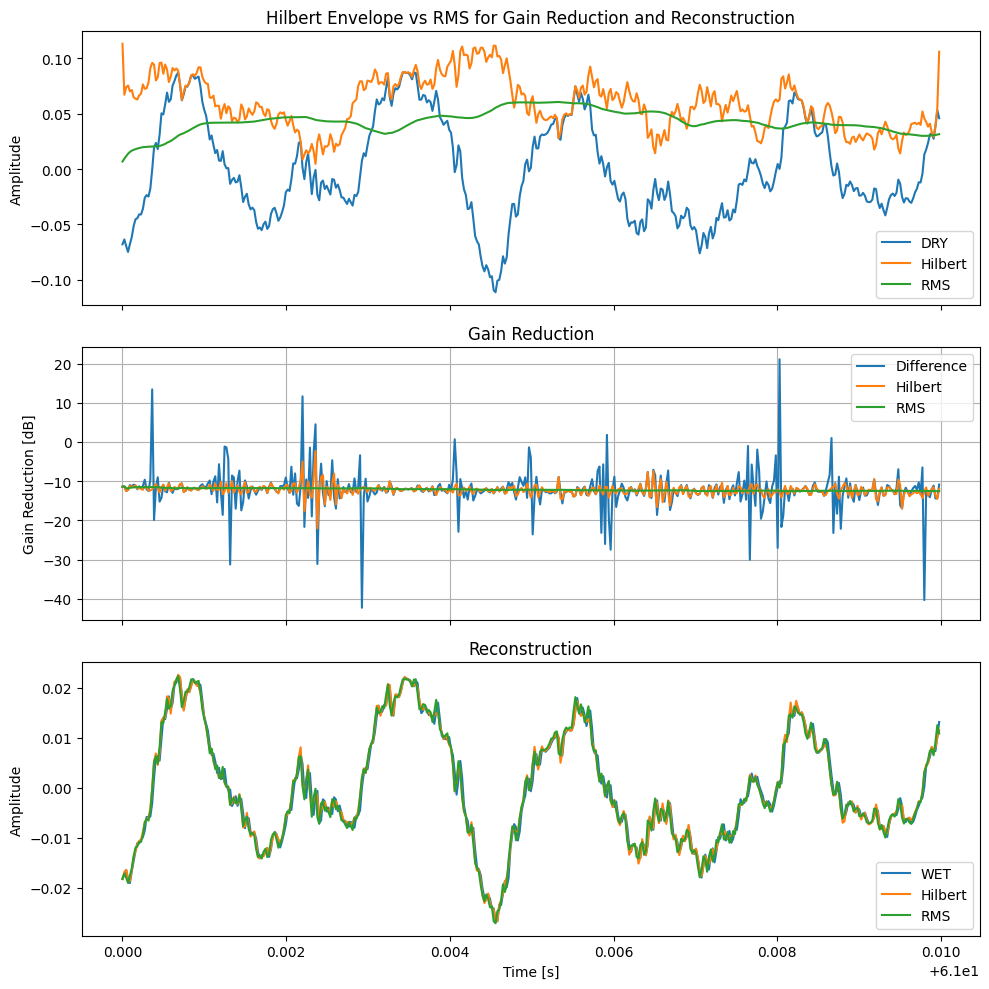

In [2]:
t_start = 61
t_length = 0.01
window_size = 100

# Load dry audio
path = SSL_DSET_PATH+DRY_PATH+'/NosPalpitants_UnmasteredWAV.wav'
t, audio = u.load_audio(path, cut=(t_start, t_start+t_length))

# Load wet audio
path_wet = SSL_DSET_PATH+WET_PATH+'/threshold_-12_attack_30_release_0.4_ratio_10/NosPalpitants-exported.wav'
t, audio_wet = u.load_audio(path_wet, cut=(t_start, t_start+t_length))

# compute difference
diff = audio_wet / audio

# Compute envelopes for dry signal
analytic_signal = hilbert(audio)
amplitude_envelope_pre_dB = np.abs(analytic_signal)
amplitude_envelope = u.to_dB(amplitude_envelope_pre_dB)
rms = u.window_rms(audio, window_size, in_dB=False)
rms_dB = u.to_dB(rms)

# Compute envelopes for wet signal
analytic_signal_wet = hilbert(audio_wet)
amplitude_envelope_wet_pre_dB = np.abs(analytic_signal_wet)
amplitude_envelope_wet = u.to_dB(amplitude_envelope_wet_pre_dB)
rms_wet = u.window_rms(audio_wet, window_size, in_dB=False)
rms_wet_dB = u.to_dB(rms_wet)

# Compute gain reduction in dB
gr_dB = amplitude_envelope_wet - amplitude_envelope
gr_rms_dB = rms_wet_dB - rms_dB

# Convert gain reduction to amplitude
gr = u.to_amplitude(gr_dB)
gr_rms = u.to_amplitude(gr_rms_dB)

# Recreate signals by applying gain reduction
recreated_signal = audio * gr
recreated_signal_rms = audio * gr_rms

# PLOTTING
fig, ax = plt.subplots(nrows=3, sharex='all', tight_layout=True, figsize=(10, 10))
ax[0].set_title("Hilbert Envelope vs RMS for Gain Reduction and Reconstruction")
ax[0].set_ylabel("Amplitude")
ax[0].plot(t, audio, label='DRY')
ax[0].plot(t, amplitude_envelope_pre_dB, label='Hilbert')
ax[0].plot(t, rms, label='RMS')
ax[0].legend()

ax[1].set_title("Gain Reduction")
ax[1].set_ylabel("Gain Reduction [dB]")
ax[1].plot(t, u.to_dB(np.abs(diff)), label='Difference')
ax[1].plot(t, gr_dB, label='Hilbert')
ax[1].plot(t, gr_rms_dB, label='RMS')
ax[1].grid()
ax[1].legend()

ax[2].set_title("Reconstruction")
ax[2].set_ylabel("Amplitude")
ax[2].set_xlabel("Time [s]")
ax[2].plot(t, audio_wet, label='WET')
ax[2].plot(t, recreated_signal, label='Hilbert')
ax[2].plot(t, recreated_signal_rms, label='RMS')
ax[2].legend()

plt.show()

# Loss Calculations

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [4]:
signal_wet = torch.as_tensor(audio_wet, dtype=torch.float32)
signal_hilbert = torch.as_tensor(recreated_signal, dtype=torch.float32)
signal_rms = torch.as_tensor(recreated_signal_rms, dtype=torch.float32)

loss_function = nn.L1Loss()
loss_hilbert = loss_function(signal_hilbert, signal_wet)
loss_rms = loss_function(signal_rms, signal_wet)

print(f"MAE Loss Hilbert: \t{loss_hilbert.item()}")
print(f"MAE Loss RMS: \t\t{loss_rms.item()}")


MAE Loss Hilbert: 	0.0008703731000423431
MAE Loss RMS: 		0.001276389230042696


# Export Gain Reduction

In [5]:
from metadata_extractor import build_dataset_dataframe
import pandas as pd


DATA_ROOT = "/Volumes/Production Tools/coding_projs/THESIS/data_preprocesses/data/Diff-SSL-G-Comp"

# Build the dataset
df = build_dataset_dataframe(DATA_ROOT)
df.head()

,song_name,dry_path,wet_path,threshold,attack,release,ratio
0,54,/Volumes/Production Tools/coding_projs/THESIS/...,/Volumes/Production Tools/coding_projs/THESIS/...,-12,30,0.4,10
1,5thFloor,/Volumes/Production Tools/coding_projs/THESIS/...,/Volumes/Production Tools/coding_projs/THESIS/...,-12,30,0.4,10
2,ALittleLate,/Volumes/Production Tools/coding_projs/THESIS/...,/Volumes/Production Tools/coding_projs/THESIS/...,-12,30,0.4,10
3,AMiLado,/Volumes/Production Tools/coding_projs/THESIS/...,/Volumes/Production Tools/coding_projs/THESIS/...,-12,30,0.4,10
4,APictureOfShit,/Volumes/Production Tools/coding_projs/THESIS/...,/Volumes/Production Tools/coding_projs/THESIS/...,-12,30,0.4,10


In [ ]:
results = []
for idx, row in df.iterrows():
    print(idx, row['song_name'])
    # Load audio files
    _, audio_dry = u.load_audio(row['dry_path'], sr=SR)
    _, audio_wet = u.load_audio(row['wet_path'], sr=SR)

    # Ensure same length
    min_len = min(len(audio_dry), len(audio_wet))
    audio_dry = audio_dry[:min_len]
    audio_wet = audio_wet[:min_len]

    # Calculate gain reduction
    gr_rms_dB = u.calc_gain_reduction(
        audio_dry, audio_wet, window_size
    )

    result = {
        "filename": row['song_name'],
        "gr_rms_dB": gr_rms_dB,
    }
    results.append(result)
gr_df = pd.DataFrame(results)
gr_df

0 54
1 5thFloor


/Users/domonkos/thesis/Virtual-Analogue-Compressor-Modelling/dset_filtering/utils.py:59: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(signal / ref)


2 ALittleLate
3 AMiLado
4 APictureOfShit
5 AReasonToLeave
6 ASailorOnceMore
7 AccessDenied
8 Agony
9 AiguilleRouge
10 Air
11 AllSoulsMoon
12 AllTheSame
13 AmorQueLucha
14 AncoraQui
15 Animal
16 AnotherDayCalling
17 AnotherLife
18 AnotherLife2
19 Attention
20 AyniNehirde
21 BackFromTheStart
22 BackInTime
23 BackroomInTulsa
24 BananaSplit
25 Bankroll
26 BigDummyShake
27 BigMansDeath
28 BitchIsParanoid
29 Bitter
30 Blue
31 BoatRide
32 Borderline
33 BurningBridges
34 CanYouSayTheSame
35 CarnivalCharade
36 CatchTheWave
37 Celebrate
38 CentauriB
39 Chasque
40 ChristmasBlues
41 ClinicA
42 CogInTheMachine
43 Cold
44 ComeAround
45 Convertible
46 Copper
47 CrazyForMe
48 DadsGlad
49 DasFunkeren
50 DeadEnemies
51 DenyControl
52 Directions
53 DoNotStand
54 DontPleaseStay
55 DragMeDown
56 DreamState
57 DuneRider


/Users/domonkos/thesis/Virtual-Analogue-Compressor-Modelling/dset_filtering/utils.py:53: RuntimeWarning: invalid value encountered in subtract
  gr_rms_dB = rms_wet - rms


58 DustYouAndMe
59 DyingLight
60 EasyTiger
61 Ecstasy
62 Electrvm
63 ElizaJane
64 EnDance
65 EnglishActor
66 EverybodysFallingApart
67 Eyeliner
68 Facade
69 Femme
70 Fever
71 Flames
72 FlecheDOr
73 FleshAndBone
74 FloresDeAbril
75 Fool
76 GetOutOfBed
77 GhostBitch
78 Gimme
79 GotYourLove
80 HammerDown
81 Hawaii
82 Headspace
83 HeartOnMyThumb
84 HeyCarrieAnne
85 HoldMe2
86 IfYouSay
87 IfYouWantSuccess
88 IncidenteEnIntag
89 Interlude
90 IsYouIsOrIsYouAint
91 Islets
92 JapanSong
93 JedenWinter
94 JesuJoy
95 JoesBar
96 JumpAcross
97 JustOneMinute
98 Kaathaadi
99 KakTvoiDelaVova
100 KingOfTheWeekend


In [ ]:
df.to_pickle('data.pkl')